In [1]:
%load_ext autoreload
%autoreload 2 

# Plot gradient norms

In [2]:
import torch
import crocoddyl
import numpy as np
import matplotlib.pyplot as plt
from feedforwardnet import FNet, jacobian, hessian
from utils import solve_crocoddyl, random_array, griddata
%matplotlib inline

In [3]:
net = torch.load('fnet.pth')

In [4]:
xtest = griddata(70)
print(xtest.shape)

(4900, 3)


In [5]:
def crocoddyl_gradient_norms(xtest):
    solutions = []
    for xyz in xtest:
        ddp = solve_crocoddyl(xyz)
        solutions.append(ddp)


    vx    = []
    vxx   = []
    cost  = []


    for ddp in solutions:

        diff1  = np.array(ddp.Vx)
        diff2  = np.array(ddp.Vxx)

        vx.append([np.linalg.norm(diff1[0])])
        vxx.append([np.linalg.norm(diff2[0])])

        cost.append([ddp.cost])



    vx    = np.array(vx).reshape(-1, 1)
    vxx   = np.array(vxx).reshape(-1, 1)
    cost  = np.array(cost).reshape(-1,1)
    return cost, vx, vxx


In [6]:
def network_gradient_norms(net, xtest):
    cost = net(torch.tensor(xtest, dtype=torch.float32)).detach().numpy().reshape(-1,1)
    
    true_gradient      = []
    approx_hessian     = []
    true_hessian       = []

    states = torch.tensor(xtest, dtype=torch.float32)
    
    for state in states:
        
        state.requires_grad = True
        
        # True gradient
        grad = jacobian(net(state), state)
        true_gradient.append(np.linalg.norm(grad.detach().numpy()))
        #print(grad)
        
        # True Hessian
        _hessian = hessian(net(state), state).detach().numpy()
        true_hessian.append(np.linalg.norm(_hessian))
        #print(_hessian)
        
        # Estimating from Jacobian
        newton = grad.T @ grad
        newton_hessian = newton.detach().numpy()
        approx_hessian.append(np.linalg.norm(newton_hessian))

        
    true_gradient    =  np.array(true_gradient).reshape(-1, 1)
    true_hessian     =  np.array(true_hessian).reshape(-1,1)
    approx_hessian   =  np.array(approx_hessian).reshape(-1, 1)
    
    return cost, true_gradient, true_hessian, approx_hessian

In [9]:
# Get the corresponding predictions for vx and vxx and cost from squared net

cost_pred, net_gradient, net_hessian, net_approx_hessian = network_gradient_norms(net, xtest)

cost, vx, vxx = crocoddyl_gradient_norms(xtest)

Text(0.5, 1.0, 'norm Vxx')

<Figure size 432x288 with 0 Axes>

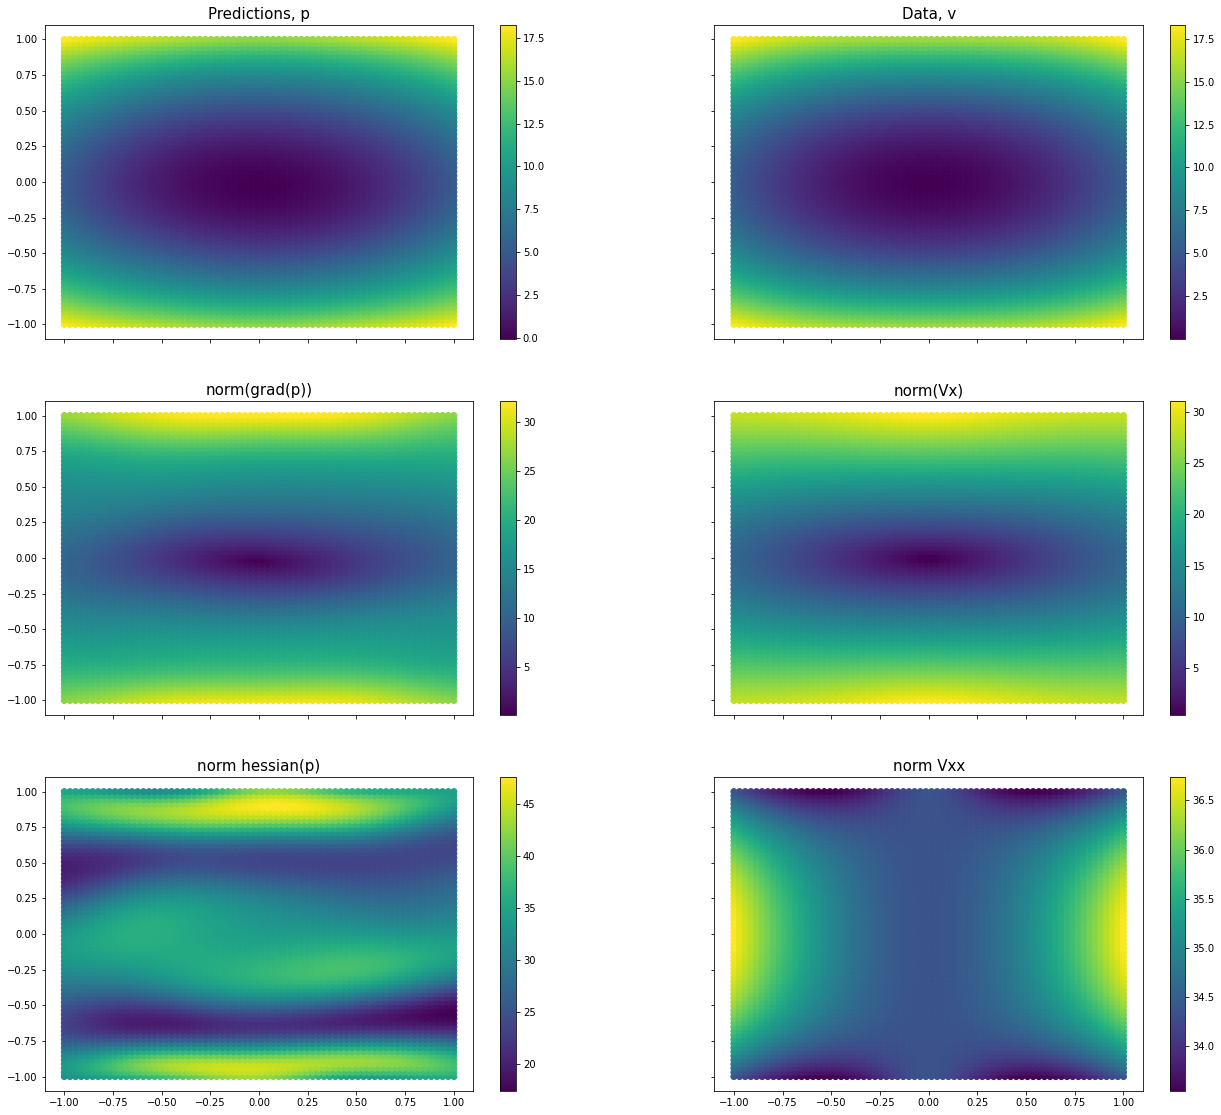

In [10]:
plt.clf()

# Make the figure:

fig, axs = plt.subplots(3, 2, figsize=(18, 20), sharex=True, sharey ='row')
fig.subplots_adjust(left=0.02, bottom=0.2, right=0.95, top=0.94, wspace=0.25)

# Plot prediction, cost
im1 = axs[0, 0].scatter(x = xtest[:,0], y = xtest[:,1], c= cost_pred)
fig.colorbar(im1, ax=axs[0, 0])


im2 = axs[0, 1].scatter(x = xtest[:,0], y = xtest[:,1], c= cost)
fig.colorbar(im2, ax=axs[0, 1])



im3 = axs[1, 0].scatter(x = xtest[:,0], y = xtest[:,1], c=  net_gradient)
fig.colorbar(im3, ax=axs[1, 0])

im4 = axs[1, 1].scatter(x = xtest[:,0], y = xtest[:,1], c=  vx)
fig.colorbar(im4, ax=axs[1, 1])


im5 = axs[2, 0].scatter(x = xtest[:,0], y = xtest[:,1], c=  net_hessian)
fig.colorbar(im5, ax=axs[2, 0])

im6 = axs[2, 1].scatter(x = xtest[:,0], y = xtest[:,1], c=  vxx)
fig.colorbar(im6, ax=axs[2, 1])




# Set titles
axs[0, 0].set_title("Predictions, p", fontsize  = 15)
axs[0, 1].set_title("Data, v", fontsize  = 15)

axs[1, 0].set_title("norm(grad(p))", fontsize  = 15)
axs[1, 1].set_title("norm(Vx)", fontsize  = 15)
axs[2, 0].set_title("norm hessian(p)", fontsize  = 15)
axs[2, 1].set_title("norm Vxx", fontsize  = 15)
